# Data Loading and Preprocessing Steps

In [10]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.

In [24]:
import os
import numpy
import pandas
import tensorflow
import shutil
import zipfile
import cv2
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

# Pre-trained Models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet201

# Model Defs
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive

from sklearn import preprocessing
from sklearn.model_selection import train_test_split




In [12]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:

zip_path = "/content/drive/MyDrive/ISIC_2019_Training_Input.zip"
ground_truth_path = "/content/drive/MyDrive/ISIC_2019_Training_GroundTruth - Copy.csv"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
labels_df = pandas.read_csv(ground_truth_path)
images = labels_df['image'].values + '.jpg'
labels = labels_df['target'].values


source_dir = '/content/image'
output_dir = 'output'
benign_dir = '/content/output/benign'
malignant_dir = '/content/output/malignant'


os.makedirs(benign_dir, exist_ok=True)
os.makedirs(malignant_dir, exist_ok=True)

benign_images = []
malignant_images = []

for img, label in zip(images, labels):
    src_path = os.path.join(source_dir, img)
    if label == 0:
        benign_images.append(img)
    elif label == 1:
        malignant_images.append(img)

for img in benign_images:
    src_path = os.path.join(source_dir, img)
    dst_path = os.path.join(benign_dir, img)
    shutil.copy(src_path, dst_path)

for img in malignant_images:
    src_path = os.path.join(source_dir, img)
    dst_path = os.path.join(malignant_dir, img)
    shutil.copy(src_path, dst_path)

In [14]:

data_dir = '/content/output'

train_ds = tensorflow.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

val_ds = tensorflow.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)


Found 25331 files belonging to 2 classes.
Using 20265 files for training.
Found 25331 files belonging to 2 classes.
Using 5066 files for validation.


In [17]:
normalization_layer = tensorflow.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

AUTOTUNE = tensorflow.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Definition

In [18]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
densenet = DenseNet201(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in vgg.layers:
    layer.trainable = False

for layer in resnet.layers:
    layer.trainable = False

for layer in densenet.layers:
    layer.trainable = False


def add_layers(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = layers.Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model

num_classes = 2
vgg_head = add_layers(vgg, num_classes)
resnet_head = add_layers(resnet, num_classes)
densenet_head = add_layers(densenet, num_classes)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True )

model1 = Model(inputs=vgg.input, outputs=vgg_head)
model2 = Model(inputs=resnet.input, outputs=resnet_head)
model3 = Model(inputs=densenet.input, outputs=densenet_head)

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [20]:
BATCH_SIZE = 32
EPOCHS = 10

checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath='vgg_model.keras',
    monitor='val_loss',
    save_best_only=True,
)

history1 = model1.fit(
  train_ds,
  epochs=EPOCHS,
  validation_data=val_ds,
  verbose=1,
  callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.7895 - loss: 0.9608 - val_accuracy: 0.8405 - val_loss: 0.3831
Epoch 2/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.8518 - loss: 0.3618 - val_accuracy: 0.8411 - val_loss: 0.3774
Epoch 3/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.8604 - loss: 0.3430 - val_accuracy: 0.8478 - val_loss: 0.3665
Epoch 4/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.8641 - loss: 0.3233 - val_accuracy: 0.8531 - val_loss: 0.3730
Epoch 5/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.8654 - loss: 0.3146 - val_accuracy: 0.8464 - val_loss: 0.3644
Epoch 6/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.8722 - loss: 0.3003 - val_accuracy: 0.8439 - val_loss: 0.3849
Epoch 7/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.8803 - loss: 0.2858 - val_accuracy: 0.8516 - val_loss: 0.3675
Epoch 8/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.8863 - loss: 0.2718 - 

In [21]:
checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath='resnet_model.keras',
    monitor='val_loss',
    save_best_only=True,
)

history2 = model2.fit(
  train_ds,
  epochs=EPOCHS,
  validation_data=val_ds,
  verbose=1,
  callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.8243 - loss: 0.4698 - val_accuracy: 0.8486 - val_loss: 0.3537
Epoch 2/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8579 - loss: 0.3431 - val_accuracy: 0.8567 - val_loss: 0.3409
Epoch 3/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8665 - loss: 0.3264 - val_accuracy: 0.8563 - val_loss: 0.3390
Epoch 4/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8735 - loss: 0.3031 - val_accuracy: 0.8529 - val_loss: 0.3425
Epoch 5/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8787 - loss: 0.2885 - val_accuracy: 0.8589 - val_loss: 0.3361
Epoch 6/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8879 - loss: 0.2637 - val_accuracy: 0.8604 - val_loss: 0.3455
Epoch 7/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8967 - loss: 0.2498 - val_accuracy: 0.8583 - val_loss: 0.3415
Epoch 8/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9044 - loss: 0.2318 - 

In [22]:
checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath='densenet_model.keras',
    monitor='val_loss',
    save_best_only=True,
)

history3 = model3.fit(
  train_ds,
  epochs=EPOCHS,
  validation_data=val_ds,
  verbose=1,
  callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 105s 101ms/step - accuracy: 0.8057 - loss: 0.8175 - val_accuracy: 0.8417 - val_loss: 0.3831
Epoch 2/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.8443 - loss: 0.3833 - val_accuracy: 0.8423 - val_loss: 0.3834
Epoch 3/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.8466 - loss: 0.3711 - val_accuracy: 0.8458 - val_loss: 0.3723
Epoch 4/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.8476 - loss: 0.3656 - val_accuracy: 0.8476 - val_loss: 0.3703
Epoch 5/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.8520 - loss: 0.3551 - val_accuracy: 0.8468 - val_loss: 0.3641


In [23]:
loss, acc = model1.evaluate(val_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8492 - loss: 0.3573
Test Loss: 0.36442822217941284
Test Accuracy: 0.8464271426200867


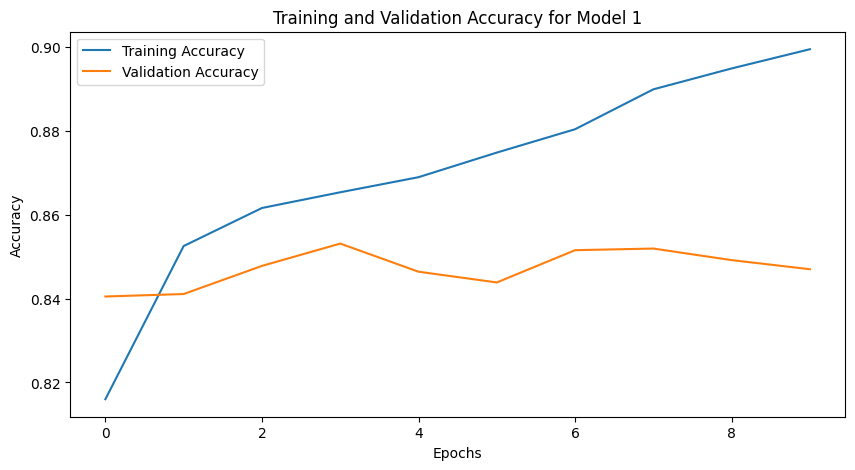

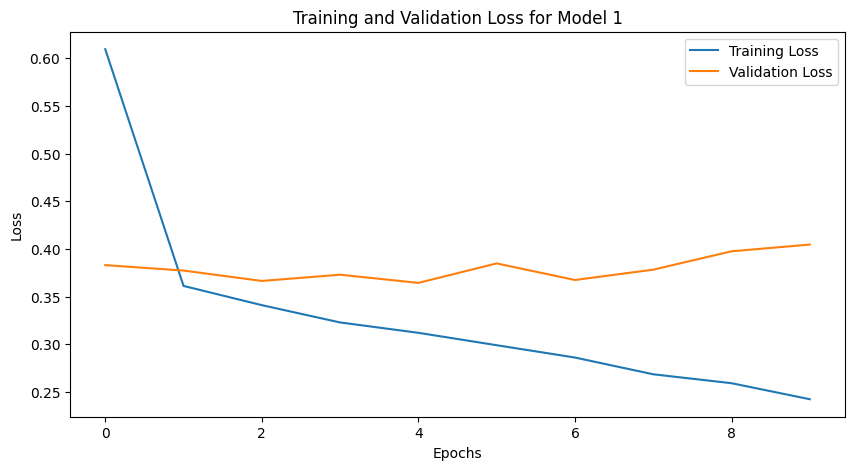

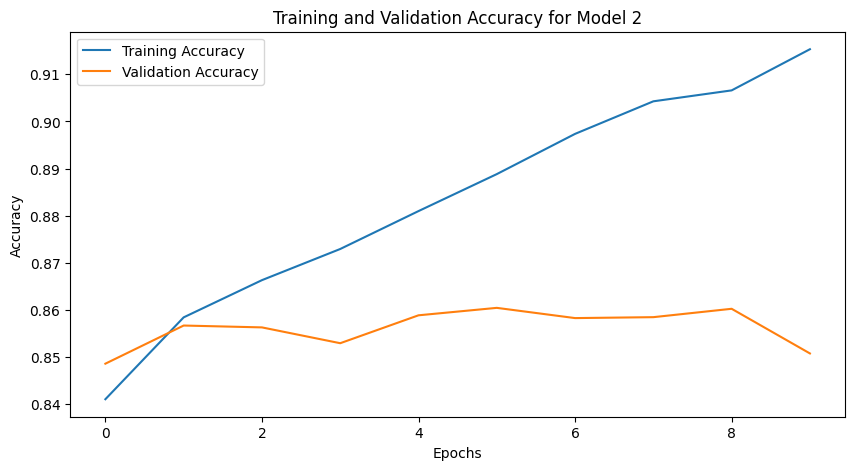

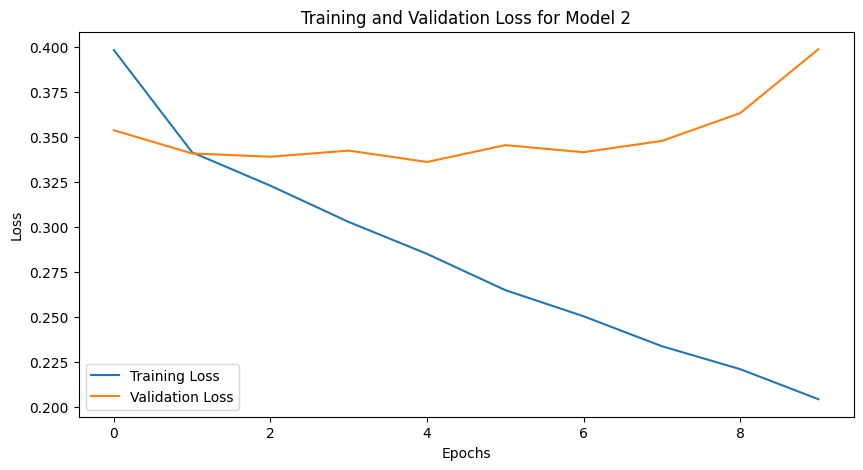

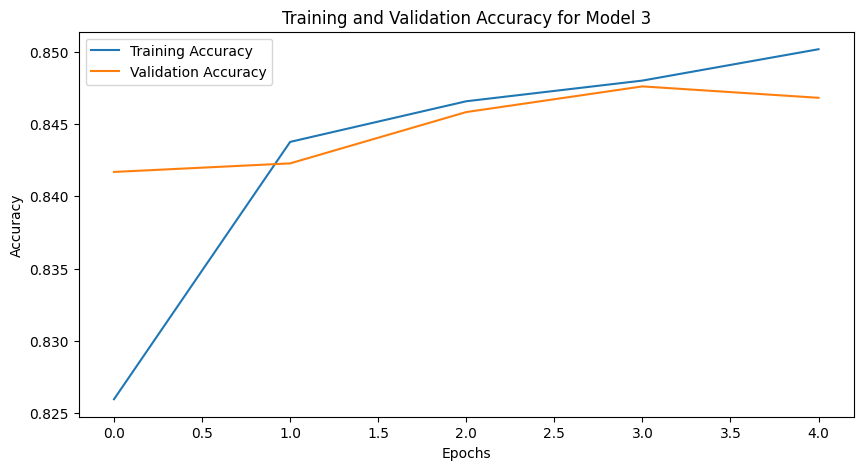

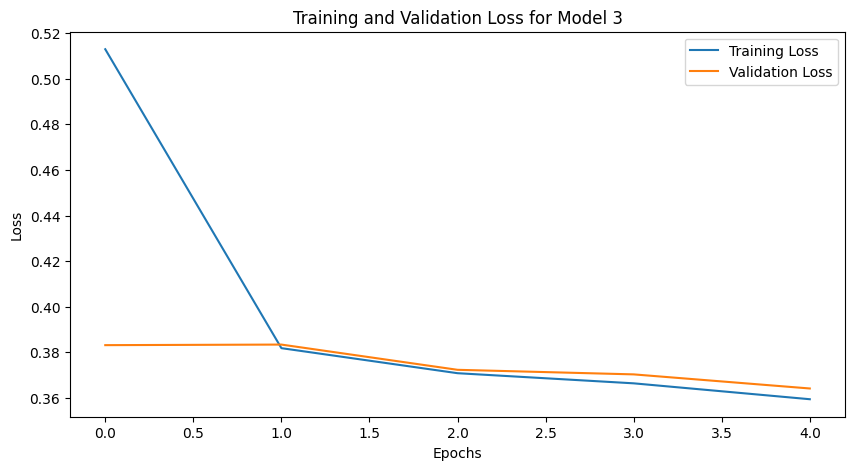

In [26]:

histories = [history1, history2, history3]

labels = ['Model 1', 'Model 2', 'Model 3']

for i, history in enumerate(histories):

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {labels[i]}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {labels[i]}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [27]:
model1.save('vgg_model.h5')
model2.save('resnet_model.h5')
model3.save('densenet_model.h5')

In [29]:

import tensorflow as tf

# Load the saved models
model1 = tf.keras.models.load_model('vgg_model.h5')
model2 = tf.keras.models.load_model('resnet_model.h5')
model3 = tf.keras.models.load_model('densenet_model.h5')

def preprocess_image(image):
    image = cv2.resize(image, (128, 128))
    image = image / 255.0
    return image

def predict_single_model(image, model):
    if image is None:
        return "Please provide an image."
    processed_image = preprocess_image(image)
    input_image = np.expand_dims(processed_image, axis=0)
    prediction = model.predict(input_image)
    class_index = np.argmax(prediction)
    class_labels = ['Benign', 'Malignant']
    predicted_class = class_labels[class_index]
    confidence = prediction[0][class_index]
    return f"{predicted_class} (Confidence: {confidence:.2f})"

def predict_vgg(image):
    return predict_single_model(image, model1)

def predict_resnet(image):
    return predict_single_model(image, model2)

def predict_densenet(image):
    return predict_single_model(image, model3)

def predict_ensemble(vgg_image, resnet_image, densenet_image):
    # Ensure all images are provided
    if vgg_image is None or resnet_image is None or densenet_image is None:
        return "Please provide images for all models."

    # Preprocess images
    vgg_processed = preprocess_image(vgg_image)
    resnet_processed = preprocess_image(resnet_image)
    densenet_processed = preprocess_image(densenet_image)

    # Make predictions
    vgg_pred = model1.predict(np.expand_dims(vgg_processed, axis=0))
    resnet_pred = model2.predict(np.expand_dims(resnet_processed, axis=0))
    densenet_pred = model3.predict(np.expand_dims(densenet_processed, axis=0))

    # Average predictions
    avg_pred = (vgg_pred + resnet_pred + densenet_pred) / 3

    class_index = np.argmax(avg_pred)
    class_labels = ['Benign', 'Malignant']
    predicted_class = class_labels[class_index]
    confidence = avg_pred[0][class_index]

    return f"Ensemble Prediction: {predicted_class} (Confidence: {confidence:.2f})"

# Create Gradio Blocks
with gr.Blocks(title="Skin Lesion Classifier") as demo:
    gr.Markdown("# Skin Lesion Classifier")
    gr.Markdown("Upload images of skin lesions to classify them as benign or malignant using different models.")

    with gr.Row():
        vgg_input = gr.Image(type="numpy", label="VGG16 Input")
        resnet_input = gr.Image(type="numpy", label="ResNet50 Input")
        densenet_input = gr.Image(type="numpy", label="DenseNet201 Input")

    with gr.Row():
        vgg_output = gr.Textbox(label="VGG16 Prediction")
        resnet_output = gr.Textbox(label="ResNet50 Prediction")
        densenet_output = gr.Textbox(label="DenseNet201 Prediction")

    ensemble_output = gr.Textbox(label="Ensemble Prediction")

    vgg_button = gr.Button("Predict with VGG16")
    resnet_button = gr.Button("Predict with ResNet50")
    densenet_button = gr.Button("Predict with DenseNet201")

    vgg_button.click(predict_vgg, inputs=vgg_input, outputs=vgg_output)
    resnet_button.click(predict_resnet, inputs=resnet_input, outputs=resnet_output)
    densenet_button.click(predict_densenet, inputs=densenet_input, outputs=densenet_output)

# Launch the interface
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a0a8c5b627d93440e5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
